In [1]:
import pydicom
import SimpleITK
import os
import numpy
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [30]:
PathDicom = "./Downloads/Compressed/PAT029/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file is DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [31]:
lstFilesDCM[:10]

['./Downloads/Compressed/PAT029/D0001.dcm',
 './Downloads/Compressed/PAT029/D0002.dcm',
 './Downloads/Compressed/PAT029/D0003.dcm',
 './Downloads/Compressed/PAT029/D0004.dcm',
 './Downloads/Compressed/PAT029/D0005.dcm',
 './Downloads/Compressed/PAT029/D0006.dcm',
 './Downloads/Compressed/PAT029/D0007.dcm',
 './Downloads/Compressed/PAT029/D0008.dcm',
 './Downloads/Compressed/PAT029/D0009.dcm',
 './Downloads/Compressed/PAT029/D0010.dcm']

In [32]:
PAT029Ds = pydicom.read_file(lstFilesDCM[0])

In [33]:
PAT029Ds.PatientPosition

'HFS'

In [34]:
PAT029Ds.StudyDate

'0'

In [35]:
PAT029Ds.Modality

'CT'

In [41]:
CalcPixelDims = (int(PAT029Ds.Rows), int(PAT029Ds.Columns), len(lstFilesDCM))

In [42]:
CalcPixelDims

(512, 512, 197)

In [45]:
PAT029ImgArray = numpy.zeros(CalcPixelDims, dtype=PAT029Ds.pixel_array.dtype)

for filenameDCM in lstFilesDCM:
    ds = pydicom.read_file (filenameDCM)
    PAT029ImgArray[: ,:, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

In [46]:
CalcPixelSpacing = (float(PAT029Ds.PixelSpacing[0]), float(PAT029Ds.PixelSpacing[1]), float(PAT029Ds.SliceThickness))

In [50]:
x = numpy.arange(0.0, (CalcPixelDims[0]+1)*CalcPixelSpacing[0], CalcPixelSpacing[0])
y = numpy.arange(0.0, (CalcPixelDims[1]+1)*CalcPixelSpacing[1], CalcPixelSpacing[0])
z = numpy.arange(0.0, (CalcPixelDims[2]+1)*CalcPixelSpacing[2], CalcPixelSpacing[0])

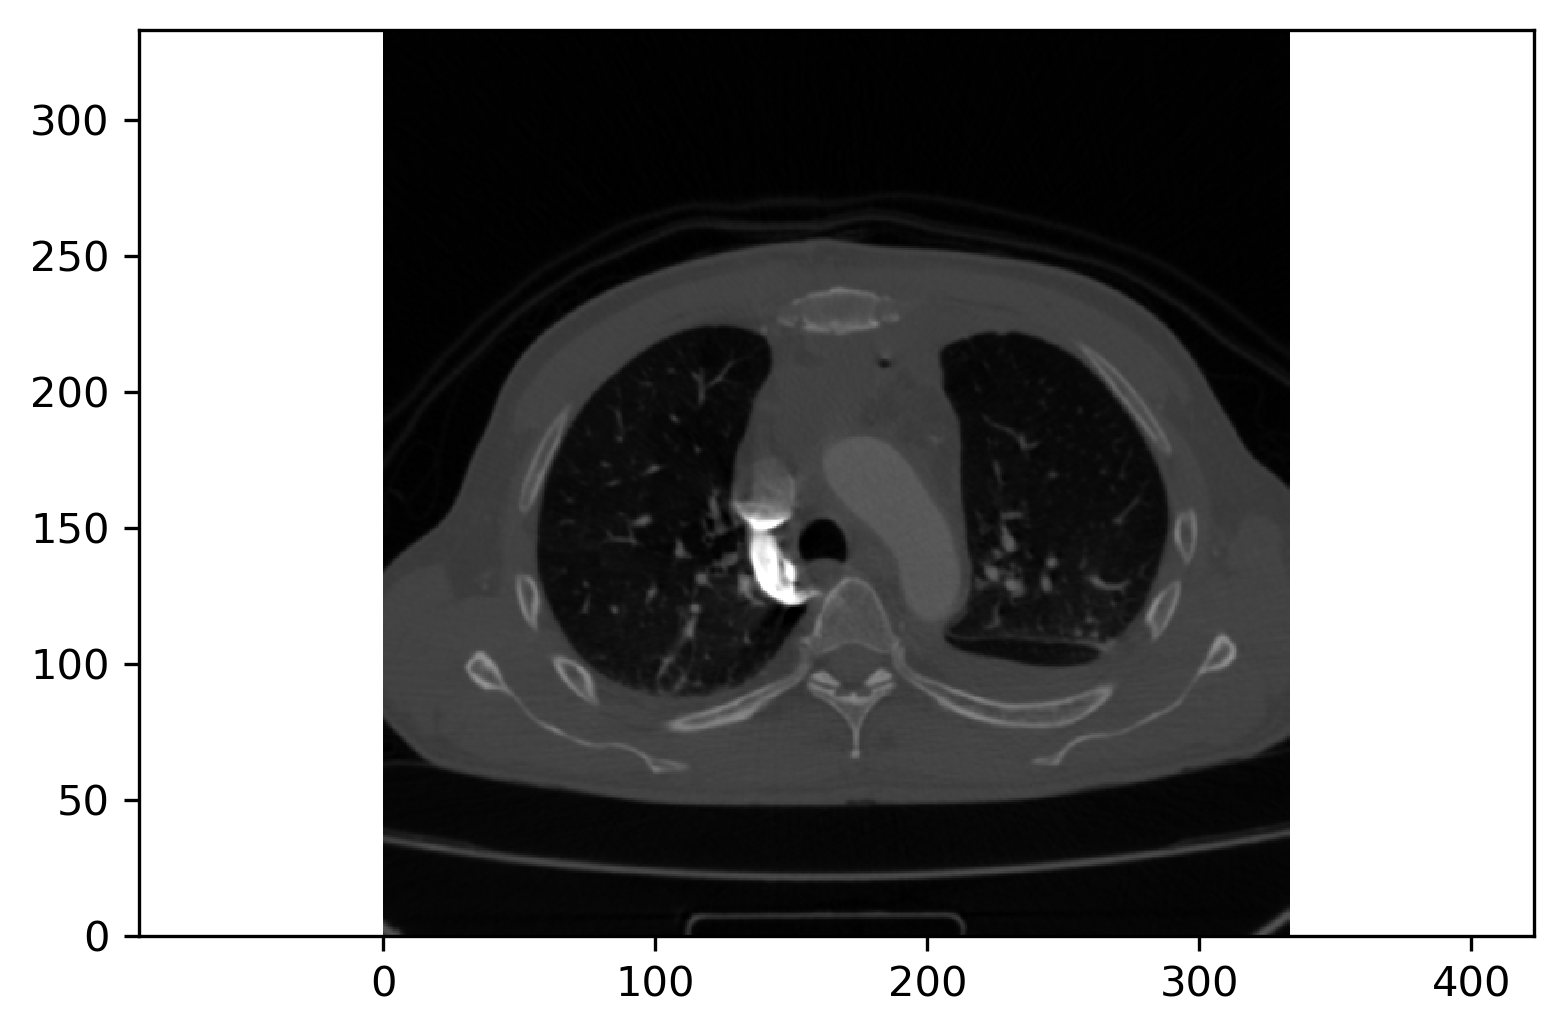

In [51]:
plt.figure(dpi=300)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(x,y,numpy.flipud(PAT029ImgArray[:, :, 125]))

In [52]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [53]:
reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(PathDicom)
reader.SetFileNames(filenamesDICOM)
img3DOriginal = reader.Execute()

In [54]:
imgOriginal = img3DOriginal[:,:,50]

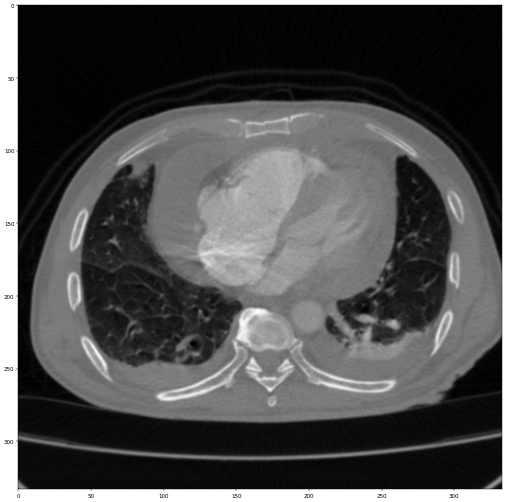

In [55]:
sitk_show(imgOriginal)

In [56]:
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                    timeStep=0.125,
                                    numberOfIterations=5)

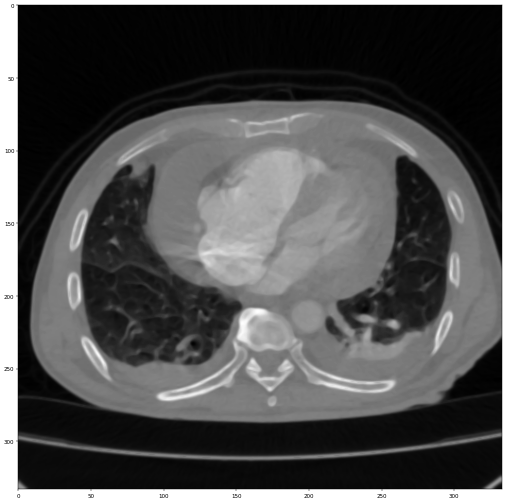

In [57]:
sitk_show(imgSmooth)

In [58]:
lstSeeds = [(150,75)]

imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=130, 
                                              upper=190,
                                              replaceValue=1)

In [59]:
imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

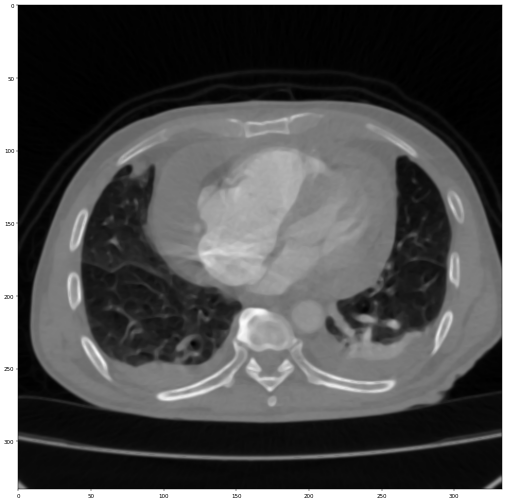

In [60]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

In [61]:
imgWhiteMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=1)

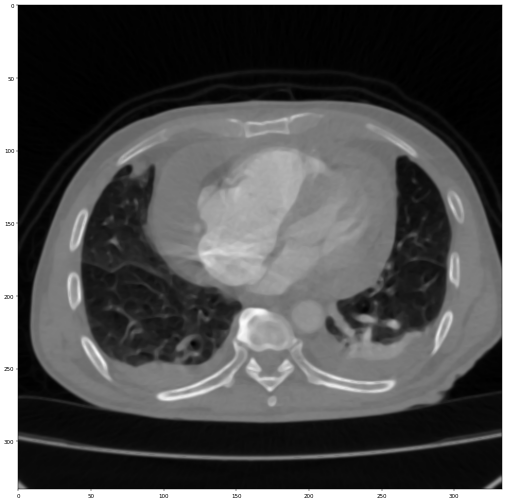

In [62]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

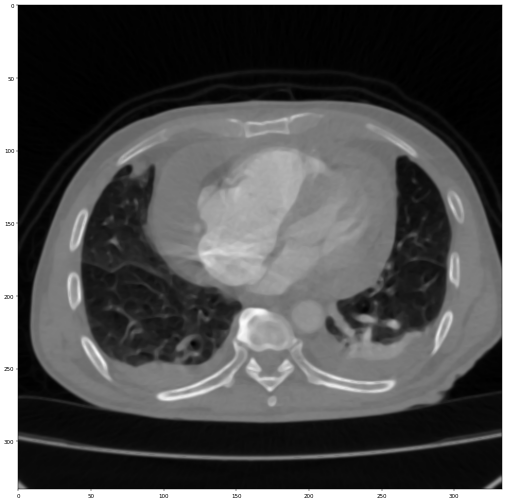

In [63]:
lstSeeds = [(119, 83), (198, 80), (185, 102), (164, 43)]

imgGreyMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                             seedList=lstSeeds, 
                                             lower=150, 
                                             upper=270,
                                             replaceValue=2)

imgGreyMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgGreyMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=2) # labelGrayMatter

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgGreyMatterNoHoles))

In [64]:
imgLabels = imgWhiteMatterNoHoles | imgGreyMatterNoHoles

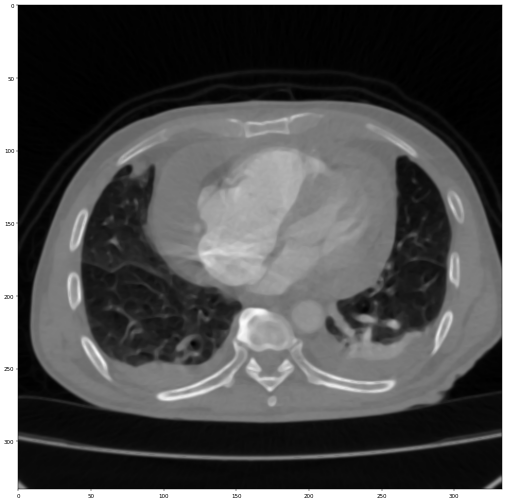

In [65]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

In [66]:
imgMask = (imgWhiteMatterNoHoles/1) * (imgGreyMatterNoHoles/2)
imgMask2 = SimpleITK.Cast(imgMask, imgWhiteMatterNoHoles.GetPixelIDValue())
imgWhiteMatterNoHoles = imgWhiteMatterNoHoles - (imgMask2*1)
imgLabels2 = imgWhiteMatterNoHoles + imgGreyMatterNoHoles

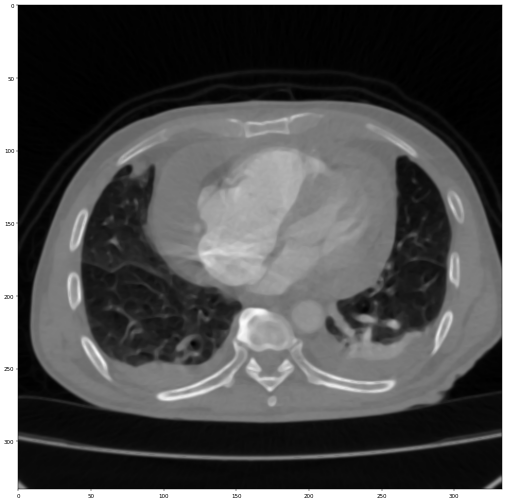

In [67]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels2))